In [3]:
%load_ext autoreload
%autoreload 2
import os

import mlflow
import numpy as np
from dotenv import load_dotenv

from src.functions import create_model, plot_data, check_gpus, create_train_val_datasets, load_stations_from_path, \
    create_test_datasets, plot_keras_history
from src.utils import now_formatted, setup_logger, format_with_border, measure_execution_time

2023-11-16 10:28:31.000491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 10:28:31.000526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 10:28:31.000564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 10:28:31.009289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
check_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2023-11-16 10:28:33.186428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 10:28:33.191831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 10:28:33.192034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
load_dotenv()
mlflow_port = os.getenv('MLFLOW_PORT')
mlflow_uri = f'http://localhost:{mlflow_port}'
mlflow_experiment_name = f'Benchmark'
train_path = os.getenv('LS_LABELED_TRAIN_DATA_PATH')
test_path = os.getenv('LS_LABELED_TEST_DATA_PATH')
log_file_path = '/tmp/benchmark.log'

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(mlflow_experiment_name)
mlflow.tensorflow.autolog()

2023/11/16 10:28:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [6]:
SEQUENCE_LENGTH = 20
TARGET_START_INDEX = SEQUENCE_LENGTH - 1
FEATURE_COLUMNS = ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
TARGET_COLUMN = 'no_snow'
DATE_COLUMN = 'measure_date'
SPLIT_PERCENTAGE = 0.8
DATASET_BATCH_SIZE = 64

# Model configuration
MODEL_ARCHITECTURE = "128(l)-64-8(d)-1"
MODEL_INPUT_SHAPE = (SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
MODEL_DROPOUT_RATE = 0.5
MODEL_OPTIMIZER = 'adam'
MODEL_METRICS = ['accuracy']
MODEL_LOSS = 'binary_crossentropy'
MODEL_BATCH_SIZE = 64
MODEL_EPOCHS = 20

def log_parameters(logging, mlflow):
    global_vars = globals()
    for var_name, value in global_vars.items():
        if var_name.isupper():
            logging.info(f'{var_name}: {value}')
            mlflow.log_param(f'benchmark_{var_name.lower()}', value)

In [7]:
training_stations = load_stations_from_path(train_path)
testing_stations = {station.iloc[0]['station_code']: station for station in load_stations_from_path(test_path)}

2023-11-16 10:28:37 INFO 104854913 - <module>: ======================================= Starting experiment =======================================
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: SEQUENCE_LENGTH: 20
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: TARGET_START_INDEX: 19
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: FEATURE_COLUMNS: ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: TARGET_COLUMN: no_snow
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: DATE_COLUMN: measure_date
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: SPLIT_PERCENTAGE: 0.8
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: DATASET_BATCH_SIZE: 64
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: MODEL_ARCHITECTURE: 128(l)-64-8(d)-1
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: MODEL_INPUT_SHAPE: (20, 5)
2023-11-16 10:28:37 INFO 1068430526 - log_parameters: MODEL_DROPOUT_RATE: 0.5
2023-11-16 10:28

2023-11-16 10:28:38.386483: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2023-11-16 10:28:40 INFO 104854913 - <module>: Training samples: 98204
2023-11-16 10:28:40 INFO 104854913 - <module>: Validation samples: 24556
2023-11-16 10:28:40 INFO 104854913 - <module>: ========================================== Fitting Model ==========================================
Epoch 1/20


2023-11-16 10:28:49.076669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-16 10:28:50.828740: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2cc16bf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 10:28:50.828770: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti with Max-Q Design, Compute Capability 6.1
2023-11-16 10:28:50.834834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 10:28:50.967674: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1535 [..............................] - ETA: 2:23:37 - loss: 0.7054 - accuracy: 0.4062WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0085s vs `on_train_batch_end` time: 0.0128s). Check your callbacks.
2023-11-16 10:28:51 WARNING callbacks - _call_batch_end_hook: Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0085s vs `on_train_batch_end` time: 0.0128s). Check your callbacks.
1535/1535 [==============================] - 24s 12ms/step - loss: 0.1892 - accuracy: 0.9240 - val_loss: 0.1470 - val_accuracy: 0.9438
Epoch 2/20
1535/1535 [==============================] - 18s 12ms/step - loss: 0.1635 - accuracy: 0.9362 - val_loss: 0.1360 - val_accuracy: 0.9501
Epoch 3/20
1535/1535 [==============================] - 21s 14ms/step - loss: 0.1553 - accuracy: 0.9406 - val_loss: 0.1363 - val_accuracy: 0.9486
Epoch 4/20
1535/1535 [==============================] - 20s 13ms/step - loss: 0.1491 - accu

2023/11/16 10:35:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/code/other/snow-height-anomaly-detection/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


2023-11-16 10:35:46 INFO 104854913 - <module>: Model fitting completed in 7m5s
2023-11-16 10:35:46 INFO 104854913 - <module>: ================================== Evaluating Model on Test Data ==================================
2023-11-16 10:35:47 INFO 104854913 - <module>: Station: TUM2, Samples: 7383, Loss: 0.10, Accuracy: 0.97
2023-11-16 10:35:47 INFO 104854913 - <module>: Station: STN2, Samples: 8889, Loss: 0.15, Accuracy: 0.95
2023-11-16 10:35:48 INFO 104854913 - <module>: Station: TRU2, Samples: 9597, Loss: 0.12, Accuracy: 0.96
2023-11-16 10:35:49 INFO 104854913 - <module>: Station: SPN2, Samples: 9599, Loss: 0.46, Accuracy: 0.88
2023-11-16 10:35:50 INFO 104854913 - <module>: Station: WFJ2, Samples: 11094, Loss: 0.22, Accuracy: 0.92


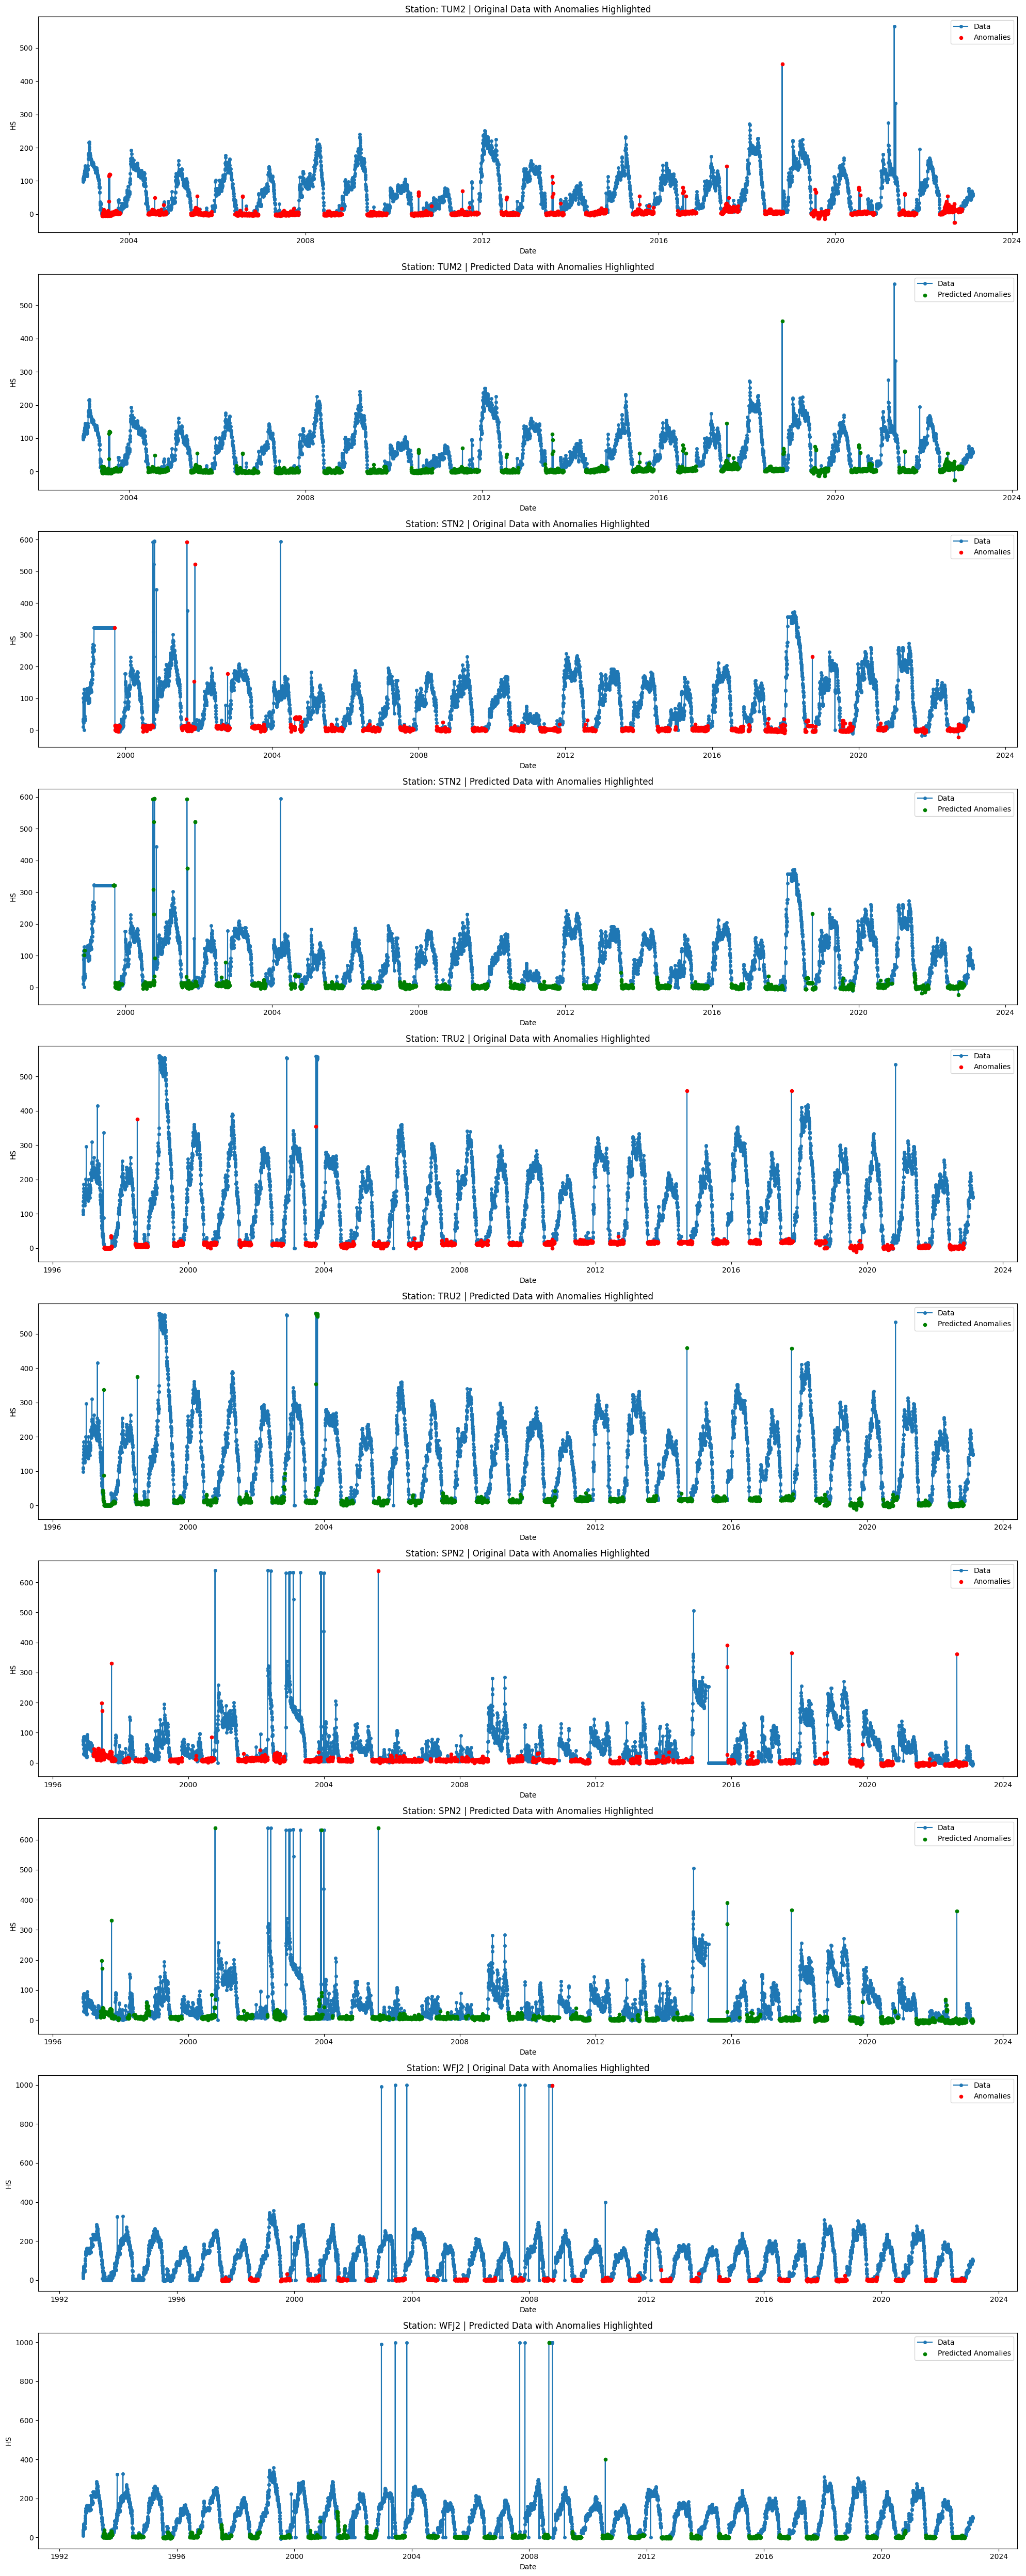

In [8]:
with mlflow.start_run(run_name=now_formatted()):
    logging, tmp_log_file = setup_logger(log_file_path=log_file_path)
    logging.info(format_with_border('Starting experiment'))
    
    log_parameters(logging, mlflow)
    logging.info(format_with_border('Preparing Training Data'))
    train_dataset, val_dataset, mean, std, num_train_samples, num_val_samples, _ = create_train_val_datasets(
        training_stations, SPLIT_PERCENTAGE, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE
    )

    logging.info(f"Training samples: {num_train_samples}")
    logging.info(f"Validation samples: {num_val_samples}")
    mlflow.log_param('benchmark_training_samples', num_train_samples)
    mlflow.log_param('benchmark_validation_samples', num_val_samples)

    model = create_model(MODEL_ARCHITECTURE, MODEL_INPUT_SHAPE, logging=None, dropout_rate=0.5, summary=False)
    model.compile(
        optimizer=MODEL_OPTIMIZER,
        metrics=MODEL_METRICS,
        loss=MODEL_LOSS
    )

    logging.info(format_with_border('Fitting Model'))
    @measure_execution_time
    def fit_model():
        return model.fit(
            train_dataset,
            epochs=MODEL_EPOCHS,
            batch_size=MODEL_BATCH_SIZE,
            validation_data=val_dataset
        )
    history, elapsed_fitting_time = fit_model()
    logging.info(f'Model fitting completed in {elapsed_fitting_time}')
    mlflow.log_param('benchmark_model_fitting_time', elapsed_fitting_time)

    logging.info(format_with_border('Evaluating Model on Test Data'))
    test_datasets = create_test_datasets(
        testing_stations.values(), FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
    )
    # TODO: Convert to shared function
    all_evaluation_results = np.empty((0, 2), float)
    for j, dataset in enumerate(test_datasets):
        evaluation_results = model.evaluate(dataset, verbose=0)
        station_name = list(testing_stations.keys())[j]
        test_df = list(testing_stations.values())[j]
        logging.info(
            f'Station: {station_name}, Samples: {len(test_df)}, Loss: {evaluation_results[0]:.2f}, Accuracy: {evaluation_results[1]:.2f}'
        )
        all_evaluation_results = np.append(all_evaluation_results, [evaluation_results], axis=0)

    mlflow.log_metric('test_avg_loss', np.mean(all_evaluation_results[:, 0]))
    mlflow.log_metric('test_avg_accuracy', np.mean(all_evaluation_results[:, 1]))
    
    # Plotting
    predictions = [model.predict(td, verbose=0).reshape((-1,)) > 0.5 for td in test_datasets]
    fig = plot_data(
        [test_station[TARGET_START_INDEX:] for test_station in testing_stations.values()],
        predictions=predictions,
        show=False
    )
    mlflow.log_figure(fig, 'prediction_results.png')
    mlflow.log_artifact(tmp_log_file)

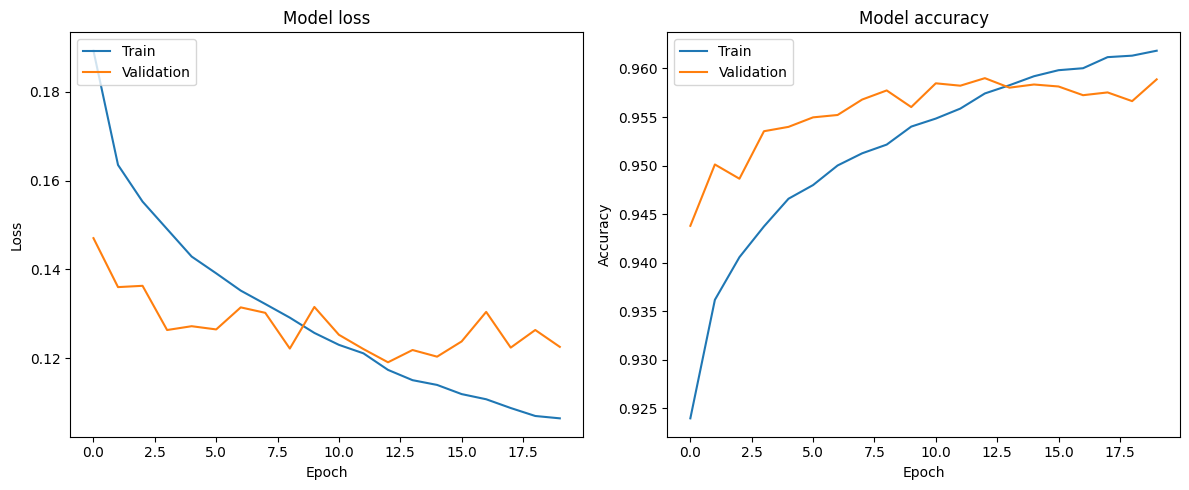

In [9]:
history_plot = plot_keras_history(history)